<a href="https://colab.research.google.com/github/piaoruilin/yunbardillo/blob/main/Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving top-10_max_weeks.csv to top-10_max_weeks.csv
Saving top-10_with_genres_keywords.csv to top-10_with_genres_keywords.csv


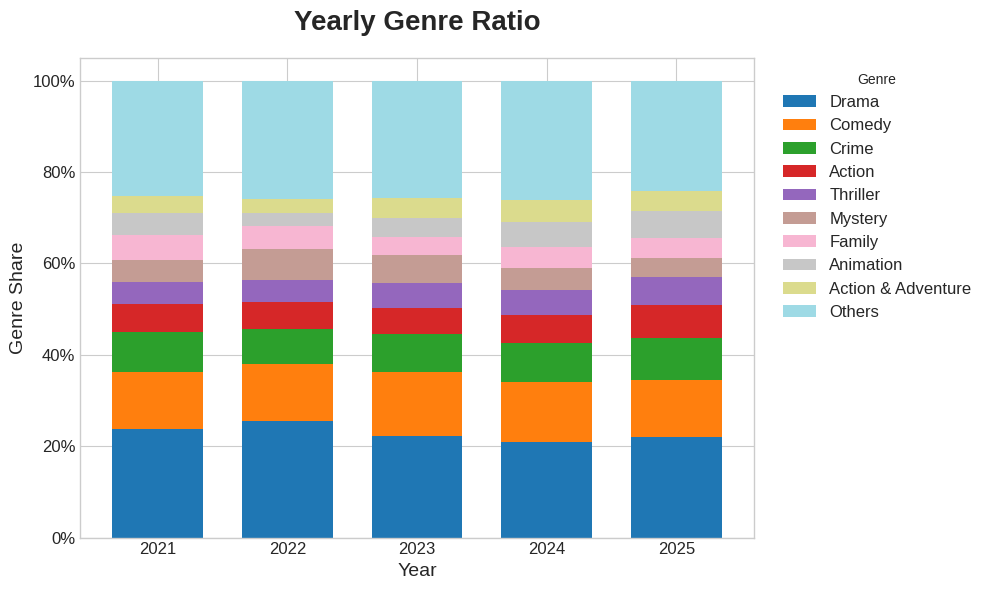

In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 데이터 준비 ---
df = pd.read_csv('top-10_with_genres_keywords.csv')
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

# 각 영화/쇼를 장르별로 분리 (explode)
df_exploded = df.explode('genres')

# --- 2. 연도별 장르 비율 계산 ---
# 연도와 장르별로 등장 횟수를 계산합니다.
genre_counts = df_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

# 피벗 테이블을 사용하여 데이터를 재구성합니다. (연도별로 장르의 등장 횟수)
pivot_df = genre_counts.pivot(index='year', columns='genres', values='count').fillna(0)

# 각 연도(행)의 합계로 나누어 비율을 계산합니다.
ratio_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# --- 3. 시각화를 위한 데이터 가공 ---
# 전체 기간 동안의 평균 비율을 기준으로 상위 9개 장르를 선정합니다.
top_genres = ratio_df.mean().nlargest(9).index

# 상위 9개 장르와 'Others'로 데이터를 재구성합니다.
df_plot = ratio_df[top_genres].copy()
df_plot['Others'] = 1 - df_plot.sum(axis=1) # 1(100%)에서 상위 장르 비율을 빼서 'Others'를 계산

# --- 4. 100% 누적 막대그래프 시각화 ---
plt.style.use('seaborn-v0_8-whitegrid')
# (수정) 그래프 크기를 (12, 7)로 줄입니다.
fig, ax = plt.subplots(figsize=(10, 6))

# 100% 누적 막대그래프를 그립니다.
df_plot.plot(kind='bar', stacked=True, ax=ax, width=0.7, cmap='tab20')

# (수정) 그래프의 제목과 축 이름을 영문으로 변경합니다.
ax.set_title('Yearly Genre Ratio', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Genre Share', fontsize=14)
ax.tick_params(axis='x', rotation=0) # x축 라벨을 수평으로 표시
ax.tick_params(axis='both', labelsize=12)

# Y축 레이블을 퍼센트(%) 형식으로 변경
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

# (수정) 범례 제목을 영문으로 변경합니다.
ax.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

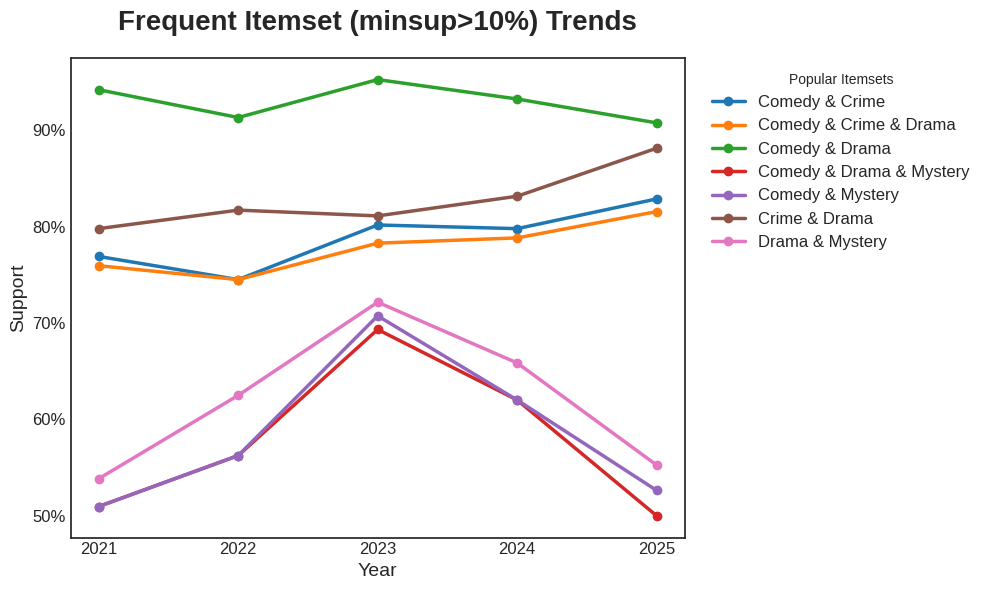

In [ ]:
import pandas as pd
import ast
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. 데이터 준비 ---
df = pd.read_csv('top-10_with_genres_keywords.csv')
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)


# --- 2. 연도별로 최소 지지도 10% 이상인 조합(Itemsets) 찾기 ---
all_frequent_itemsets = []
analysis_years = sorted(df['year'].unique())

for year in analysis_years:
    df_year = df[df['year'] == year]

    # 해당 연도의 '거래' 데이터 생성
    transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
    transactions = [list(set(item)) for item in transactions if item]

    if not transactions:
        continue

    # 데이터를 Apriori 알고리즘에 맞는 형태로 변환
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    # 최소 지지도 10%로 Apriori 알고리즘 실행
    frequent_itemsets = apriori(df_onehot, min_support=0.1, use_colnames=True)

    if not frequent_itemsets.empty:
        frequent_itemsets['year'] = year
        all_frequent_itemsets.append(frequent_itemsets)

# 전체 결과를 하나의 데이터프레임으로 합치기
trends_df = pd.concat(all_frequent_itemsets)

# --- 3. 시각화를 위한 데이터 가공 ---
# frozenset을 문자열로 변환하여 다루기 쉽게 만듭니다.
trends_df['itemset_str'] = trends_df['itemsets'].apply(lambda x: ' & '.join(sorted(list(x))))
# 2개 이상의 장르로 구성된 조합만 필터링합니다.
trends_df_pairs = trends_df[trends_df['itemsets'].apply(len) >= 2].copy()

# 전체 기간 동안 평균 지지도가 높은 상위 7개 조합을 선정합니다.
top_itemsets = trends_df_pairs.groupby('itemset_str')['support'].mean().nlargest(7).index
plot_df = trends_df_pairs[trends_df_pairs['itemset_str'].isin(top_itemsets)]

# 피벗 테이블로 데이터를 재구성합니다.
pivot_df = plot_df.pivot(index='year', columns='itemset_str', values='support')


# --- 4. 꺾은선 그래프 시각화 ---
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(10, 6))

pivot_df.plot(kind='line', marker='o', ax=ax, linewidth=2.5)

# (수정) 그래프 제목 및 레이블을 영문으로 변경
ax.set_title('Frequent Itemset (minsup>10%) Trends', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Support', fontsize=14)

# (수정) x축 눈금을 정수 연도로 강제하여 '.5년'을 제거
ax.set_xticks(pivot_df.index)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)

# Y축 레이블을 퍼센트(%) 형식으로 변경
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

# (수정) 범례 제목을 영문으로 변경
ax.legend(title='Popular Itemsets', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

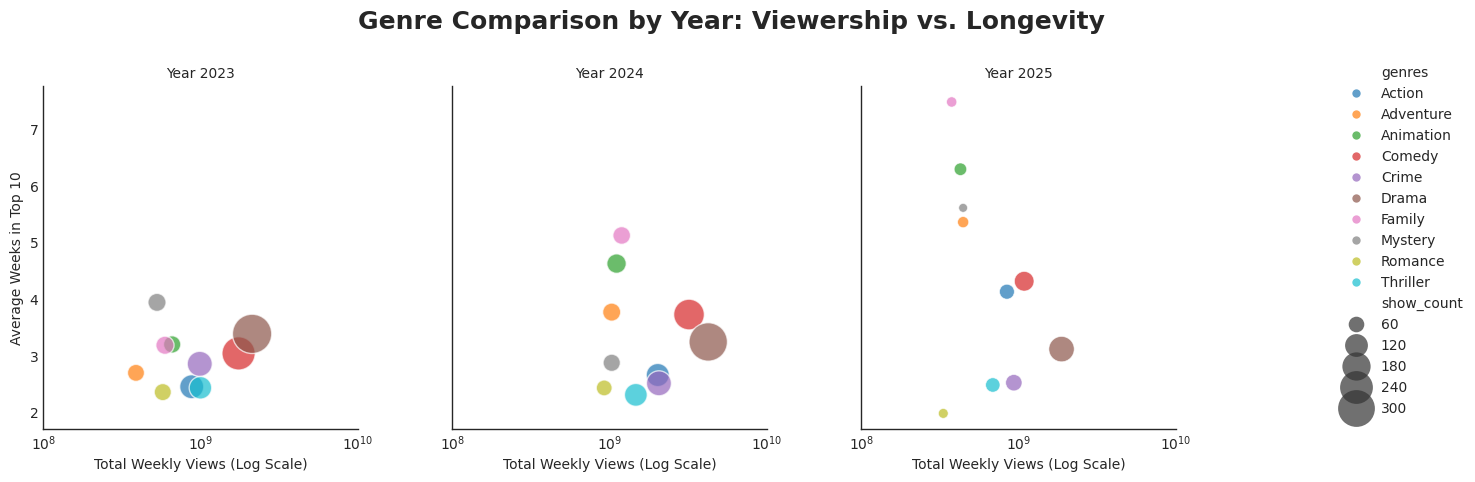

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. 데이터 준비 ---
df = pd.read_csv('top-10_with_genres_keywords.csv')
df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year
df['genres'] = df['genres'].apply(ast.literal_eval)

df_exploded = df.explode('genres')

# --- 2. 연도별/장르별 데이터 집계 ---
genre_yearly_stats = df_exploded.groupby(['year', 'genres']).agg(
    total_weekly_views=('weekly_views', 'sum'),
    avg_cumulative_weeks=('cumulative_weeks_in_top_10', 'mean'),
    show_count=('show_title', 'nunique')
).reset_index()

# 시각화할 상위 10개 장르 선정
top_genres_by_views = genre_yearly_stats.groupby('genres')['total_weekly_views'].sum().nlargest(10).index
analysis_df = genre_yearly_stats[genre_yearly_stats['genres'].isin(top_genres_by_views)]

# 2021년과 2022년 데이터 제외
analysis_df = analysis_df[~analysis_df['year'].isin([2021, 2022])]


# --- 3. 최종 그래프 시각화 ---
sns.set_style("white")

g = sns.relplot(
    data=analysis_df,
    x="total_weekly_views",
    y="avg_cumulative_weeks",
    col="year",
    hue="genres",
    size="show_count",
    sizes=(40, 800),
    alpha=0.7,
    kind="scatter",
    col_wrap=3,
    height=4.5,
    aspect=1
)

# --- 4. 그래프 기본 정보 설정 ---
g.set(xscale="log")
g.set_titles("Year {col_name}")
g.fig.suptitle('Genre Comparison by Year: Viewership vs. Longevity', fontsize=18, y=1.05, fontweight='bold')


# 상세 X축 눈금 설정
tick_values = [10**8, 10**9, 10**10]
tick_labels = ['$10^8$', '$10^9$', '$10^{10}$']

for ax in g.axes.flat:
    if not ax.has_data():
        continue
    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_labels)

# --- 5. 모든 그래프에 축 주석 추가 (수정된 부분) ---
# 기존의 g.set_axis_labels() 대신, 반복문으로 각 그래프에 축 이름을 직접 설정합니다.
for ax in g.axes.flat:
    if not ax.has_data():
        continue
    ax.set_xlabel("Total Weekly Views (Log Scale)", fontsize=10)
    ax.set_ylabel("Average Weeks in Top 10", fontsize=10)


# --- 6. 최종 레이아웃 조정 ---
g.fig.subplots_adjust(top=0.88, right=0.8, hspace=0.4, wspace=0.3)

plt.show()

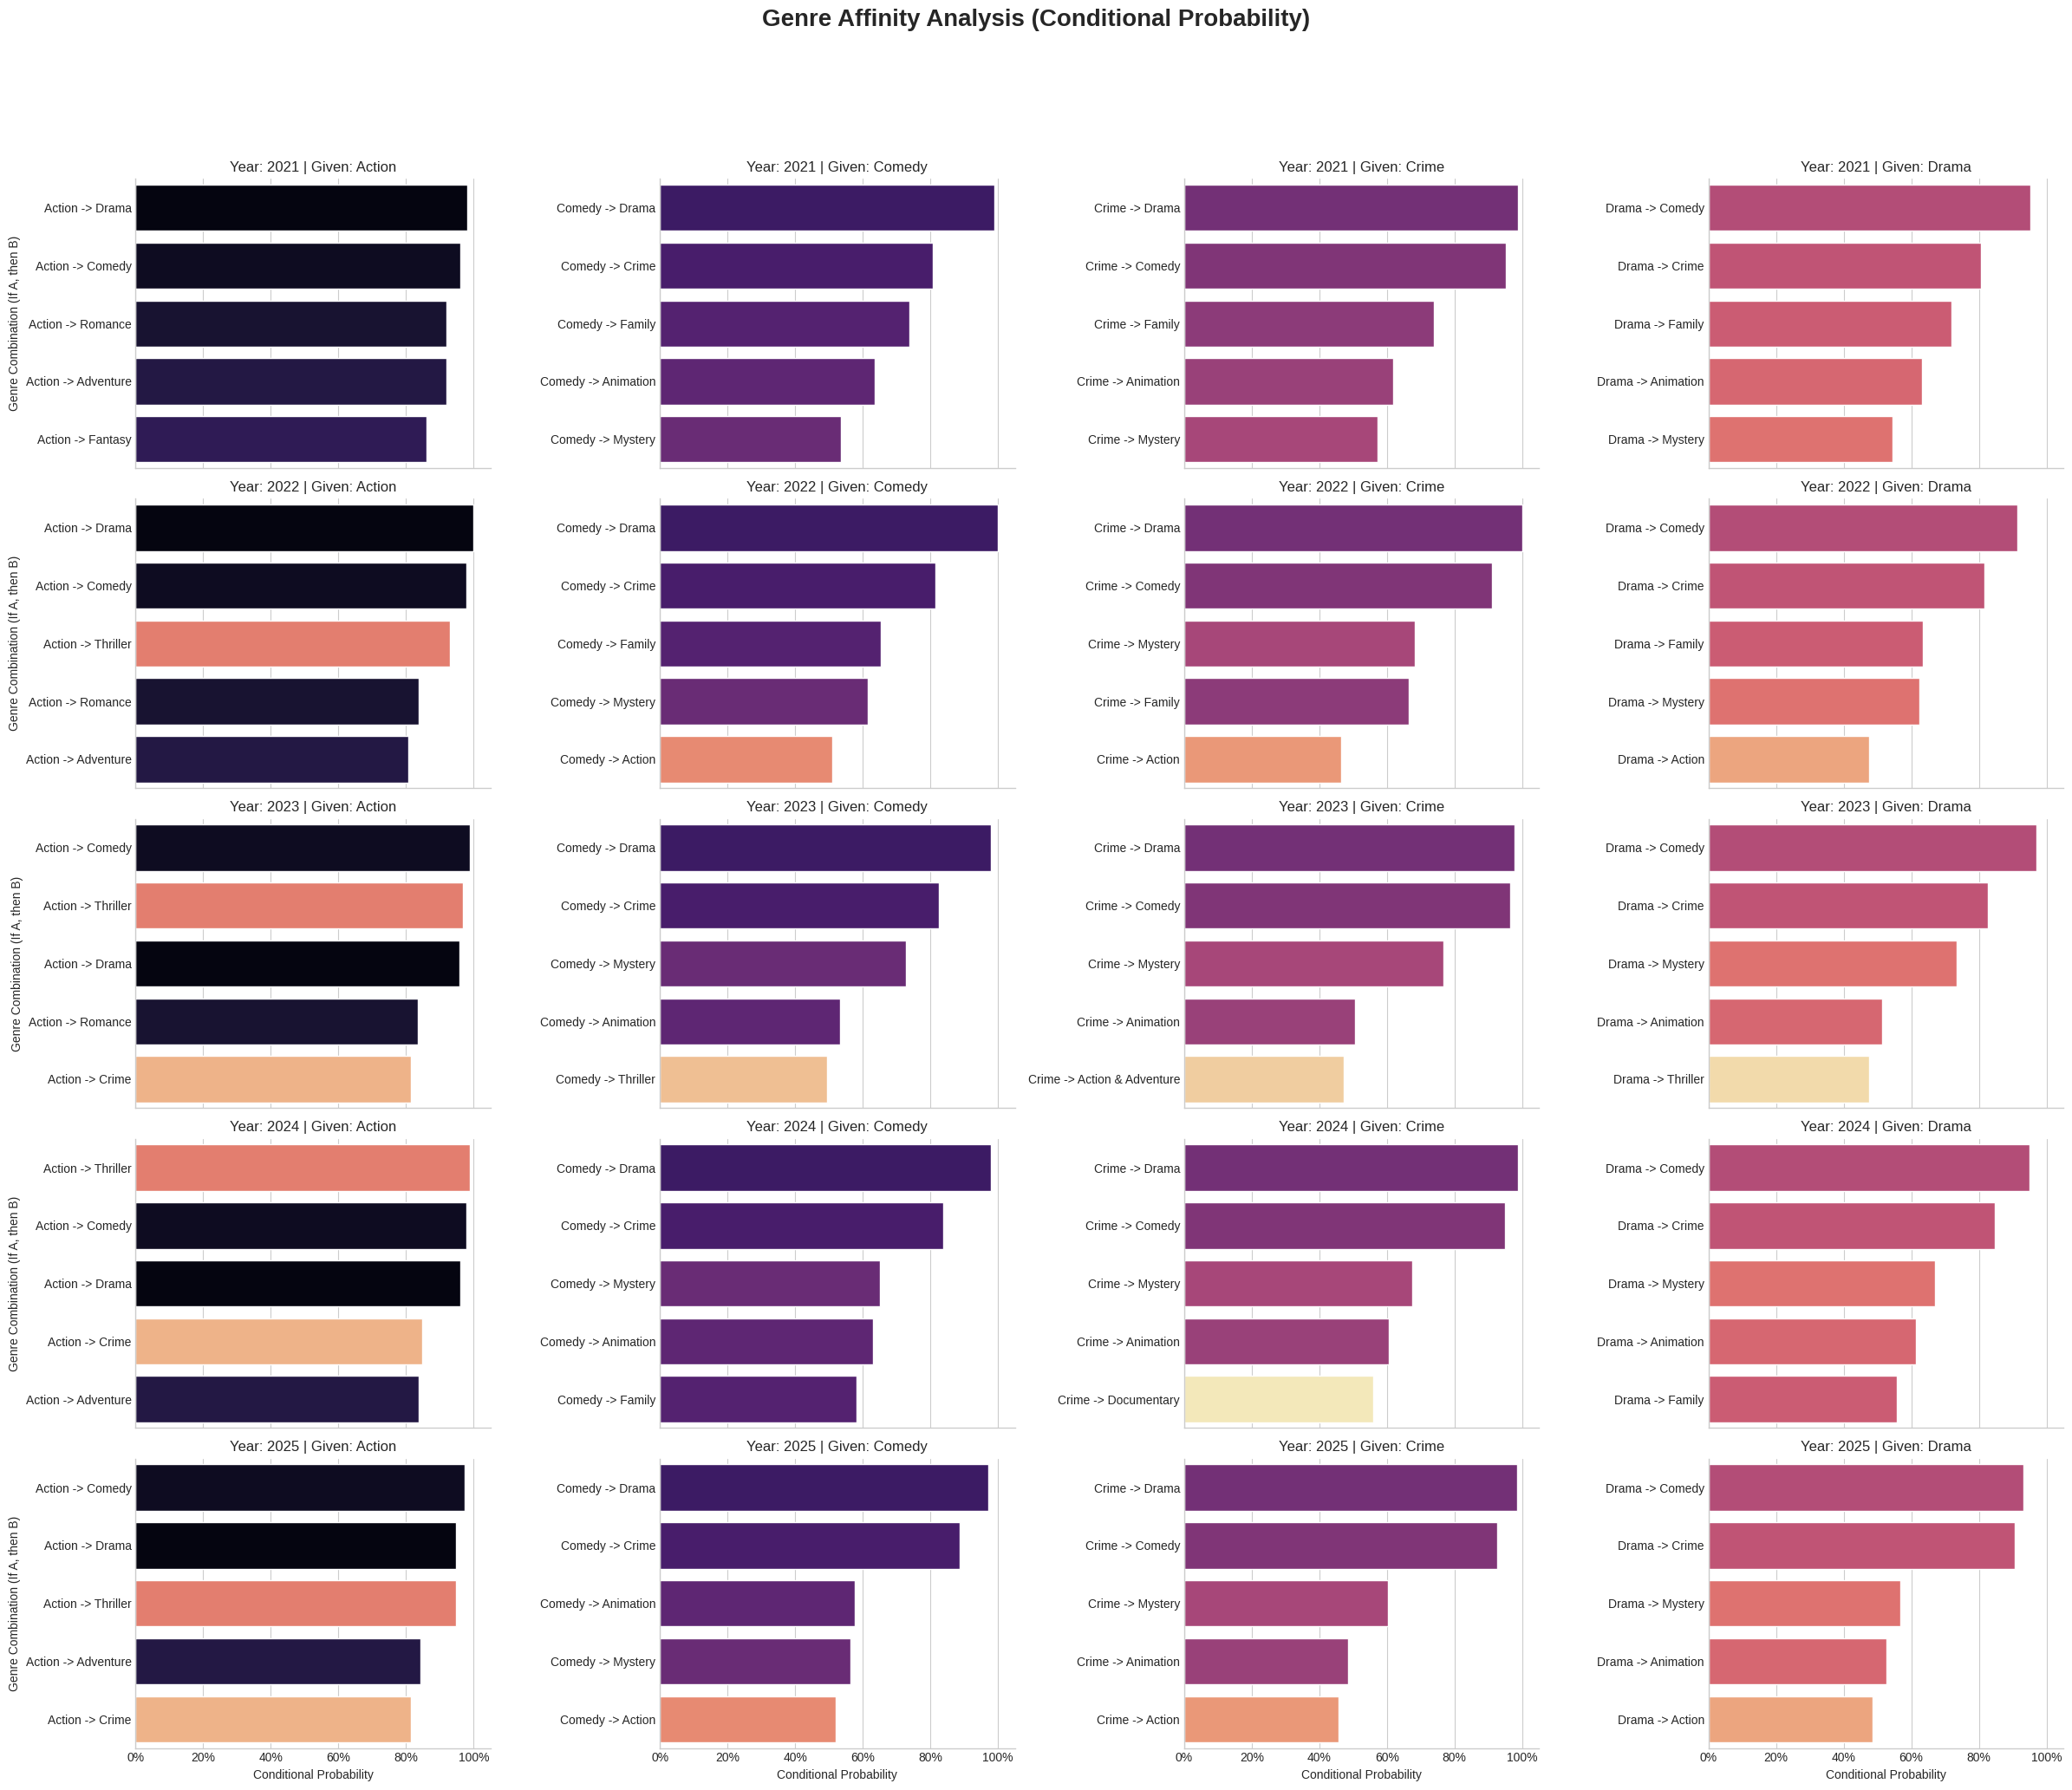

In [ ]:
  import pandas as pd
  import ast
  from itertools import permutations
  from collections import defaultdict
  import seaborn as sns
  import matplotlib.pyplot as plt
  import numpy as np # np.sum을 사용하기 위해 import

  # --- 1. 데이터 준비 ---
  df = pd.read_csv('top-10_with_genres_keywords.csv')
  df['week'] = pd.to_datetime(df['week'])
  df['year'] = df['week'].dt.year
  df['genres'] = df['genres'].apply(ast.literal_eval)


  # --- 2. 연도별 조건부 확률 계산 ---
  all_conditional_probs = []
  analysis_years = sorted(df['year'].unique())

  for year in analysis_years:
      df_year = df[df['year'] == year]

      # (수정 1) apply(sum) 대신 np.sum 사용
      transactions = df_year.groupby(['week', 'category'])['genres'].apply(np.sum).tolist()
      transactions = [list(set(item)) for item in transactions if item]

      if not transactions:
          continue

      genre_counts = defaultdict(int)
      pair_counts = defaultdict(int)

      for transaction in transactions:
          for genre in transaction:
              genre_counts[genre] += 1
          for g1, g2 in permutations(transaction, 2):
              pair_counts[(g1, g2)] += 1

      for (genre_A, genre_B), count_AB in pair_counts.items():
          count_A = genre_counts[genre_A]
          if count_A > 0:
              cond_prob = count_AB / count_A
              all_conditional_probs.append({
                  'year': year,
                  'Given_Genre': genre_A,
                  'Result_Genre': genre_B,
                  'prob': cond_prob
              })

  prob_df = pd.DataFrame(all_conditional_probs)


  # --- 3. 시각화를 위한 데이터 가공 ---
  focus_genres = ['Drama', 'Comedy', 'Crime', 'Action']
  prob_filtered = prob_df[prob_df['Given_Genre'].isin(focus_genres)]

  # (수정 2) DeprecationWarning을 해결하기 위해 더 현대적인 방식으로 코드를 수정
  top5_df = prob_filtered.sort_values(['year', 'Given_Genre', 'prob'], ascending=[True, True, False]) \
                        .groupby(['year', 'Given_Genre']) \
                        .head(5)

  top5_df['label'] = top5_df.apply(lambda row: f"{row['Given_Genre']} -> {row['Result_Genre']}", axis=1)


  # --- 4. 최종 결과 시각화 ---
  # (수정 3) hue='label' 및 legend=False 추가
  g = sns.catplot(
      data=top5_df,
      x='prob',
      y='label',
      hue='label',       # y축 변수를 hue로 지정
      col='Given_Genre',
      row='year',
      kind='bar',
      height=4,
      aspect=1.5,
      sharey=False,
      palette='magma',
      legend=False     # hue를 사용했으므로 범례는 숨김
  )

  # 그래프 제목 및 레이블 설정
  g.fig.suptitle('Genre Affinity Analysis (Conditional Probability)', fontsize=20, y=1.03, fontweight='bold')
  g.set_axis_labels('Conditional Probability', 'Genre Combination (If A, then B)')
  g.set_titles("Year: {row_name} | Given: {col_name}", size=12)

  # x축 레이블을 퍼센트(%) 형식으로 변경
  for ax in g.axes.flat:
      ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

<ipython-input-3-aeb03ab427e5>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(top_genres))
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/48q5r20y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/90d33cby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77119', 'data', 'file=/tmp/tmp1vzju8i2/48q5r20y.json', 'init=/tmp/tmp1vzju8i2/90d33cby.json', 'output', 'file=/tmp/tmp1vzju8i2/prophet_modelpocdws24/prophet_model-20250527121936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:19:36 - cmdstanpy - INFO - Chain [1] start processing


상위 9개 장르에 대한 미래 점유율 예측을 시작합니다...
분석 대상 장르: ['Drama', 'Comedy', 'Crime', 'Action', 'Thriller', 'Mystery', 'Family', 'Animation', 'Action & Adventure']


INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/21yrb1o_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/hum8xbj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42111', 'data', 'file=/tmp/tmp1vzju8i2/21yrb1o_.json', 'init=/tmp/tmp1vzju8i2/hum8xbj8.json', 'output', 'file=/tmp/tmp1vzju8i2/prophet_modelbrb6a87z/prophet_model-20250527121936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1vzju8i2/isuduq8n.json
DEBUG:cmdstanpy:input tempfile


예측이 완료되었습니다.


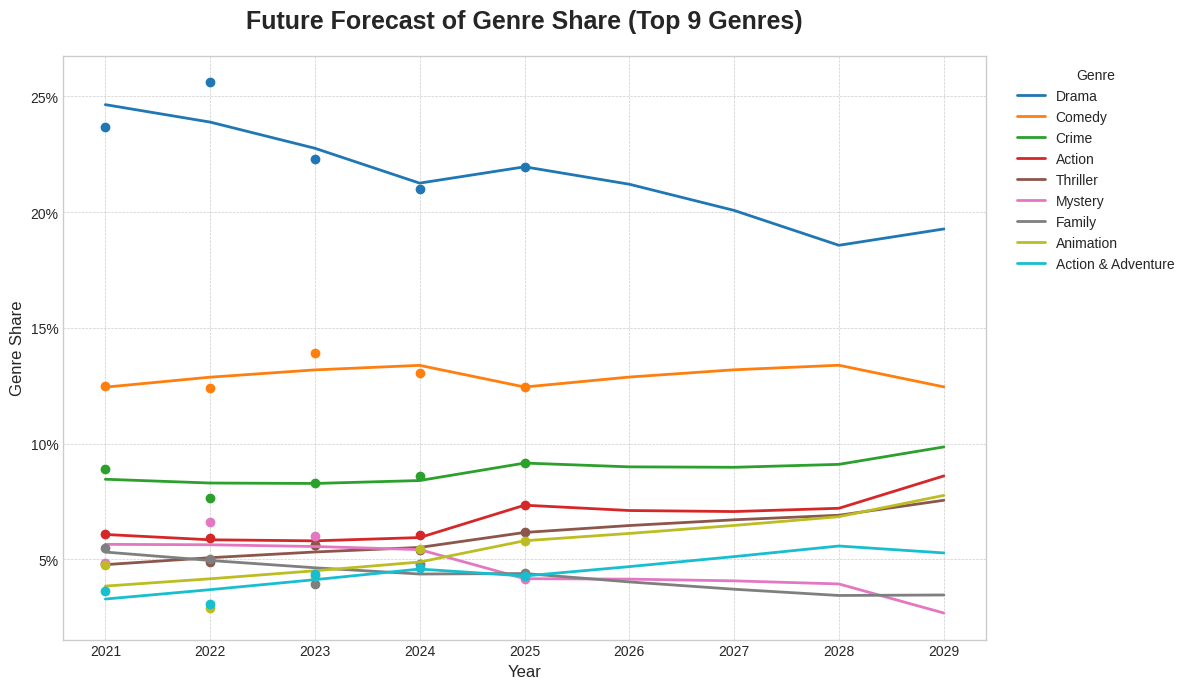


--- 향후 4년간 장르별 예상 점유율 (%) ---
      Drama  Comedy  Crime  Action  Thriller  Mystery  Family  Animation  Action & Adventure
ds                                                                                          
2026 21.21%  12.88%  9.00%   7.11%     6.46%    4.15%   4.03%      6.12%               4.69%
2027 20.08%  13.19%  8.98%   7.07%     6.71%    4.07%   3.71%      6.47%               5.12%
2028 18.57%  13.39%  9.11%   7.21%     6.91%    3.94%   3.44%      6.85%               5.58%
2029 19.28%  12.45%  9.86%   8.61%     7.56%    2.68%   3.46%      7.77%               5.28%


In [3]:
# 1. Prophet 등 필요한 라이브러리 설치
!pip install prophet pandas matplotlib

import pandas as pd
import ast
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # 색상 지정을 위해 import
import numpy as np

# --- 2. 데이터 준비 (연도별 장르 비율 계산) ---
# Colab 왼편의 파일 아이콘을 클릭하여 'top-10_with_genres_keywords.csv' 파일을 업로드해주세요.
try:
    df = pd.read_csv('top-10_with_genres_keywords.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 'top-10_with_genres_keywords.csv' 파일을 Colab에 업로드했는지 확인해주세요.")
    raise

df['week'] = pd.to_datetime(df['week'])
df['year'] = df['week'].dt.year

# 문자열로 된 리스트를 실제 리스트로 변환
df['genres'] = df['genres'].apply(ast.literal_eval)

# 각 영화/쇼를 장르별로 분리 (explode)
df_exploded = df.explode('genres')

# 연도와 장르별로 등장 횟수를 계산
genre_counts = df_exploded.groupby(['year', 'genres']).size().reset_index(name='count')

# 피벗 테이블을 사용하여 데이터를 재구성 (연도별 장르 등장 횟수)
pivot_df = genre_counts.pivot(index='year', columns='genres', values='count').fillna(0)

# 각 연도(행)의 합계로 나누어 비율을 계산
ratio_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Prophet을 위해 날짜 형식으로 인덱스 변환 ('2021' -> '2021-01-01')
ratio_df.index = pd.to_datetime(ratio_df.index.astype(str) + '-01-01')

# --- 3. 전체 장르에 대한 미래 예측 실행 ---
# 전체 기간 동안의 평균 비율을 기준으로 상위 9개 장르를 선정
top_genres = ratio_df.mean().nlargest(9).index.tolist()

# 예측 결과를 저장할 데이터프레임
all_forecasts_df = pd.DataFrame()

# 시각화를 위한 Figure 준비
plt.style.use('seaborn-v0_8-whitegrid')
# --- 그래프 크기 수정: (15, 9) -> (12, 7) ---
fig, ax = plt.subplots(figsize=(12, 7))

# 각 장르에 대한 색상 맵 생성
colors = cm.get_cmap('tab10', len(top_genres))

print(f"상위 {len(top_genres)}개 장르에 대한 미래 점유율 예측을 시작합니다...")
print(f"분석 대상 장르: {top_genres}")

for i, genre in enumerate(top_genres):
    # Prophet을 위한 데이터프레임 생성 ('ds'와 'y' 컬럼명 사용)
    prophet_df = ratio_df[[genre]].reset_index()
    prophet_df.columns = ['ds', 'y']

    # Prophet 모델 생성 및 학습
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(prophet_df)

    # 미래 예측 (향후 4년)
    future = model.make_future_dataframe(periods=4, freq='YS') # YS: 연초(Year Start) 기준
    forecast = model.predict(future)

    # 시각화: 과거 데이터(점)와 미래 예측(선)을 함께 그립니다.
    ax.plot(prophet_df['ds'], prophet_df['y'], 'o', color=colors(i), markersize=6)
    ax.plot(forecast['ds'], forecast['yhat'], '-', color=colors(i), linewidth=2, label=f'{genre}')

    # 예측 결과를 하나의 데이터프레임에 저장
    forecast_subset = forecast[['ds', 'yhat']].rename(columns={'yhat': genre})
    if all_forecasts_df.empty:
        all_forecasts_df = forecast_subset
    else:
        all_forecasts_df = pd.merge(all_forecasts_df, forecast_subset, on='ds')

print("\n예측이 완료되었습니다.")

# --- 4. 그래프 최종 설정 ---
ax.set_title('Future Forecast of Genre Share (Top 9 Genres)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Genre Share', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
ax.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- 5. 예측 결과 테이블 출력 ---
# 보기 좋게 인덱스를 연도만 표시하도록 변경
all_forecasts_df['ds'] = all_forecasts_df['ds'].dt.year
all_forecasts_df = all_forecasts_df.set_index('ds')

print("\n--- 향후 4년간 장르별 예상 점유율 (%) ---")
# 소수점을 퍼센트로 변환하여 출력
future_predictions = all_forecasts_df.tail(4) * 100
print(future_predictions.to_string(float_format='{:.2f}%'.format))